## LIBRERIAS

In [2]:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from PIL import Image
from collections import Counter
import pandas as pd
import numpy as np
import ast
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

## CARGO LOS CSV

In [ ]:
def parse_lista(cadena):
    try:
        lista = ast.literal_eval(cadena)
        return lista
    except (ValueError, SyntaxError):
        return []

In [21]:

ruta = 'vc_mariposas_sin_fondo_250_4.csv' 
df = pd.read_csv(ruta,dtype={"Y":int})

df['X'] = df['X'].apply(parse_lista) 

data_x = np.array(df['X'].tolist()) 
data_y = np.array(df['Y'].tolist())

# aplico pca
pca = PCA(n_components=25)
pca.fit(data_x)
data_pca_x = pca.transform(data_x)

#training, test y value
X_train, X_temp, y_train, y_temp = train_test_split(data_pca_x, data_y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)


In [26]:
# Clase NodoArbol para el árbol de decisión
class NodoArbol:
    def __init__(self, datos_X, datos_Y):
        self.datos_X = datos_X
        self.datos_Y = datos_Y
        self.izquierda = None
        self.derecha = None
        self.caracteristica = None
        self.umbral = None
        self.etiqueta = None

    def es_hoja(self):
        return len(set(self.datos_Y)) == 1

    def calcular_gini(self):
        conteo_etiquetas = Counter(self.datos_Y)
        impureza = 1
        total = len(self.datos_Y)

        for etiqueta, conteo in conteo_etiquetas.items():
            probabilidad = conteo / total
            impureza -= probabilidad ** 2
        return impureza

    def mejor_division(self):
        mejor_gini = float('inf')
        mejor_division = None

        for caracteristica in range(self.datos_X.shape[1]):
            valores = set(self.datos_X[:, caracteristica])

            #realizo un corte por cada 
            for valor in valores:
                mascara_izquierda = self.datos_X[:, caracteristica] < valor
                mascara_derecha = ~mascara_izquierda
                len_izquierda = sum(mascara_izquierda)
                len_derecha = sum(mascara_derecha)

                gini_izquierda = NodoArbol(self.datos_X[mascara_izquierda], self.datos_Y[mascara_izquierda]).calcular_gini()
                gini_derecha = NodoArbol(self.datos_X[mascara_derecha], self.datos_Y[mascara_derecha]).calcular_gini()

                gini_total = (len_izquierda * gini_izquierda + len_derecha * gini_derecha) / (len_izquierda + len_derecha)

                if gini_total < mejor_gini:
                    mejor_gini = gini_total
                    mejor_division = (caracteristica, valor)

        return mejor_division

# Clase Árbol de Decisión
class ArbolDecision:
    def __init__(self):
        self.raiz = None

    def entrenar(self, datos_X, datos_Y):
        self.raiz = self.crear_arbol_decision(datos_X, datos_Y)

    def crear_arbol_decision(self, datos_X, datos_Y):
        nodo = NodoArbol(datos_X, datos_Y)

        if nodo.es_hoja():
            nodo.etiqueta = datos_Y[0]
            return nodo

        mejor_division = nodo.mejor_division()

        if mejor_division is None:
            nodo.etiqueta = Counter(datos_Y).most_common(1)[0][0]
            return nodo

        caracteristica, valor = mejor_division
        nodo.caracteristica = caracteristica
        nodo.umbral = valor

        datos_X_izquierda = np.delete(datos_X, caracteristica, axis=1)
        mascara_izquierda = datos_X[:, caracteristica] < valor
        mascara_derecha = ~mascara_izquierda

        nodo.izquierda = self.crear_arbol_decision(datos_X_izquierda[mascara_izquierda], datos_Y[mascara_izquierda])
        nodo.derecha = self.crear_arbol_decision(datos_X_izquierda[mascara_derecha], datos_Y[mascara_derecha])

        return nodo

    def predecir_muestra(self, nodo, datos_x):
        if nodo.es_hoja():
            return nodo.etiqueta
        if datos_x[nodo.caracteristica] < nodo.umbral:
            return self.predecir_muestra(nodo.izquierda, datos_x)
        return self.predecir_muestra(nodo.derecha, datos_x)

    def predecir(self, datos_X):
        predicciones = [self.predecir_muestra(self.raiz, x) for x in datos_X]
        return np.array(predicciones)


Época 1/5
Error de entrenamiento en época 1: 0.8062596335779224
Error de validación en época 1: 0.8247421161214264
Época 2/5
Error de entrenamiento en época 2: 0.8170123217499654
Error de validación en época 2: 0.8436044798113764
Época 3/5
Error de entrenamiento en época 3: 0.809263925423416
Error de validación en época 3: 0.8386383731211318
Época 4/5
Error de entrenamiento en época 4: 0.8032544187549033
Error de validación en época 4: 0.8246536987916298
Época 5/5
Error de entrenamiento en época 5: 0.8019880935899211
Error de validación en época 5: 0.7954759799587385


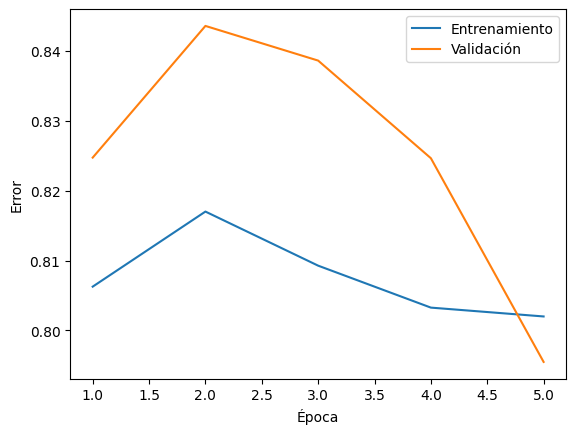

Error de prueba: 0.8160000000000001


In [27]:

error_train = []
error_val = []

kf = KFold(n_splits=5, shuffle=True)
epochs = 5;
for epoch in range(1, epochs + 1):
    print(f"Época {epochs}/{5}")
    epoch_train_errors = []
    epoch_val_errors = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        
        dec_tree = ArbolDecision()  
        dec_tree.entrenar(X_train_fold, y_train_fold)
        
        
        train_predictions = dec_tree.predecir(X_train_fold)
        train_accuracy = np.mean(train_predictions == y_train_fold)
        epoch_train_errors.append(1 - train_accuracy)
        
        
        val_predictions = dec_tree.predecir(X_val_fold)
        val_accuracy = np.mean(val_predictions == y_val_fold)
        epoch_val_errors.append(1 - val_accuracy)
    
    
    train_error_epoch = np.mean(epoch_train_errors)
    val_error_epoch = np.mean(epoch_val_errors)
    
    
    error_train.append(train_error_epoch)
    error_val.append(val_error_epoch)
    

# grafica
plt.plot(range(1, epochs + 1), error_train, label='traning')
plt.plot(range(1, epochs + 1), error_val, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

new_dec_tree = ArbolDecision()  
new_dec_tree.entrenar(X_train, y_train)

test_predictions = new_dec_tree.predecir(X_test)
test_accuracy = np.mean(test_predictions == y_test)
print(f"Error de prueba: {1 - test_accuracy}")

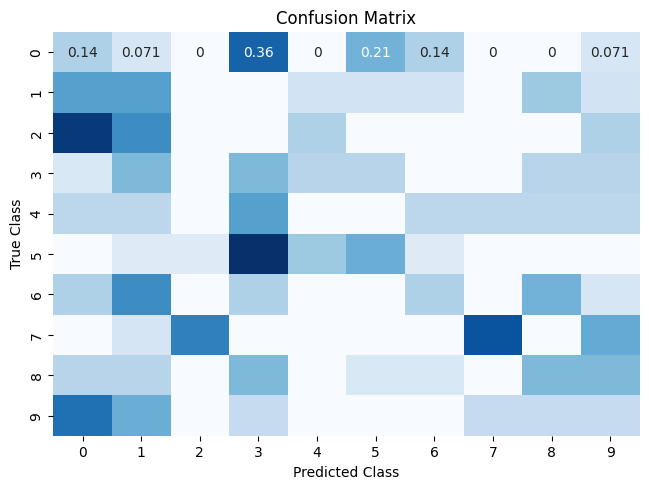

0.16536630036630037

In [29]:

def make_confusion_matrix(Y_real, Y_pred, title="Confusion Matrix"):
    cm = metrics.confusion_matrix(Y_real, Y_pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    dataframe = pd.DataFrame(cmn)

    sns.heatmap(dataframe, annot=True, cbar=False, cmap="Blues")
    plt.title(title), plt.tight_layout()
    plt.ylabel("True Class"), plt.xlabel("Predicted Class")
    plt.show()

    eff = np.nanmean(np.diagonal(cmn))
    return eff


tree = ArbolDecision()
tree.entrenar(X_train, y_train)

# Hacer predicciones
Y_pred = tree.predecir(X_test)


make_confusion_matrix(y_test, Y_pred)